Performance of solo NN 

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [3]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import sys
import glob

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc

from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.use('Agg')
%matplotlib inline

import utils
sys.path.append(".")
from utils import *

from tensorflow.python.keras.backend import set_session
from scipy.stats import pearsonr

CLASS_PARTIAL_LOSS = 0
CLASS_COMPLETELY_LOSS = 1 

TensorFlow 1.x selected.


Using TensorFlow backend.


In [4]:
def predict(models, x, use_majority=True):
  """
  Predict the output of x using the different models that were provided, if use_majority=True we use majority vote, if False we use Average vote
  :param models: A list of loaded models 
  :param x: The dataset to predict on
  :param use_majority:if use_majority=True we use majority vote, if False we use Average vote
  :return the prediction for labels 
  """
  y_pred = np.zeros(shape=(x.shape[0], len(models)))
  
  for i in range(len(models)):
    if use_majority:
      model_prediciton = np.round(models[i].predict(x))    
    else:
      model_prediciton = models[i].predict(x)

    y_pred[:,i] = model_prediciton.reshape(model_prediciton.shape[0])
  
  if use_majority:
    return np.round(np.mean(y_pred, axis=1))
  
  else:
    return np.mean(y_pred, axis=1)

def draw_confusion_matrix(y_test, y_pred):
  """
  Draw a confusion matrix based on the predictions and true labels
  :param y_test: np.array of the true labels
  :param y_pred: np.array of the predictions labels
  """
  cm = confusion_matrix(y_test, y_pred_keras)
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

def get_prediction_based_on_wcgw(x_test):
  """
  Get a prediction of dataset using the wcgw rules
  """
  pred = []
  for i  in range(len(x_test)):
    mini_seq = x_test[i][73:77]
    if mini_seq in ["ACGA", "ACGT", "TCGA", "TCGT"]:
      pred.append(CLASS_COMPLETELY_LOSS)
    else:
      pred.append(CLASS_PARTIAL_LOSS)

  return pred

def get_prediction_based_on_flank(x_train_seq, y_train, x_test, flank_size=1):
  """
  Get a prediction of dataset using dictionary of flank
  :param x_train_seq: The train set for the dictionary learning phase 
  :param y_train: The train labels for the dictionary learning phase
  :param x_test: The test dataset to predict on
  :param flank_size: The amount of flank neucliotides to use for prediciton
  :return: The prediction for the x_test
  """
  seqs_dict = {}
  for i  in range(len(x_train_seq)):
    seq = x_train_seq[i]
    mini_seq = seq[74-flank_size:76+flank_size]

    if mini_seq not in seqs_dict:
      seqs_dict[mini_seq] = 0

    if y_train[i] == 1:
      seqs_dict[mini_seq] +=1
    else:
      seqs_dict[mini_seq] -=1

  pred = []
  for i in range(len(x_test)):
    seq = x_test[i]
    mini_seq = seq[74-flank_size:76+flank_size]
    if mini_seq not in seqs_dict:
      pred.append(1)
      continue
    
    majority_vote = seqs_dict[mini_seq]
    if majority_vote >0:
      pred.append(1)
    else:
      pred.append(0)

  return pred 

In [5]:
def get_nn_performace(data_path, scwgbs_models_folder, bulk_models_folder, title, other_data):
  """
  Print a ROC curve of the NN compare to other models
  :param data_path: Path for the data
  :param scwgbs_models_folder: Path for the scwgbs models
  :parma bulk_models_folder: Path for the bulk models
  :param title: Title for the ROC curve 
  :param other_data: Other dataset we need to check our test sequences doesn't contain to prevent testing on trained sequences
  """
  print("Loading data")
  x_train_seq,y_train,_,_, x_test_seq, y_test = load_train_validate_test_data(data_path, 150, False, kfold=1)
  other_train_seq, _,_,_,_,_ = load_train_validate_test_data(other_data, 150, False, kfold=1)
  
  print("Removing bad sequences")
  trained_seq = vecs2dna(x_train_seq[0])
  other_seq_l = vecs2dna(other_train_seq[0])
  test_seq = vecs2dna(x_test_seq)
  
  shared =set(trained_seq + other_seq_l) & set(test_seq)
  good_indexes = [i for i in range(len(test_seq)) if test_seq[i] not in shared]
  x_test_seq, y_test = x_test_seq[good_indexes], y_test[good_indexes]
  test_seq = np.array(test_seq)[good_indexes]

  print("Load and predict on models")
  # Load the models 
  models_paths = glob.glob(os.path.join(scwgbs_models_folder, "*"))
  sc_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  models_paths = glob.glob(os.path.join(bulk_models_folder, "*"))
  bulk_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  # Get predictions using different models 

  sc_y_pred_keras  = predict(sc_models, x_test_seq, use_majority=False).ravel()
  bulk_y_pred_keras  = predict(bulk_models, x_test_seq, use_majority=False).ravel()
  # Get predictions based on flanking to compare to the nn
  print("Predict on basic models")
  wcgw_pred = get_prediction_based_on_wcgw(test_seq)
  flank1_pred = get_prediction_based_on_flank(trained_seq, y_train[0], test_seq, flank_size=1)
  flank2_pred = get_prediction_based_on_flank(trained_seq, y_train[0], test_seq, flank_size=2)
  # flank3_pred = get_prediction_based_on_flank(trained_seq, y_train[0], test_seq, flank_size=3)

  print("Create roc curves")
  # Compute ROC curve and AUC 
  fpr_keras_sc, tpr_keras_sc, thresholds_keras_sc = roc_curve(y_test, sc_y_pred_keras)
  auc_keras_sc = auc(fpr_keras_sc, tpr_keras_sc)

  fpr_keras_bulk, tpr_keras_bulk, thresholds_keras_bulk = roc_curve(y_test, bulk_y_pred_keras)
  auc_keras_bulk = auc(fpr_keras_bulk, tpr_keras_bulk)

  fpr_wcgw,tpr_wcgw, thresholds_wcgw = roc_curve(y_test, wcgw_pred)
  auc_wcgw = auc(fpr_wcgw, tpr_wcgw)

  fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, flank1_pred)
  auc_1 = auc(fpr_1, tpr_1)

  fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, flank2_pred)
  auc_2 = auc(fpr_2, tpr_2)

  # fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, flank3_pred)
  # auc_3 = auc(fpr_3, tpr_3)

  plt.figure(1, dpi=200)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras_sc, tpr_keras_sc, label='scWGBS NN (area = {:.3f})'.format(auc_keras_sc))
  plt.plot(fpr_keras_bulk, tpr_keras_bulk, label='zhou NN (area = {:.3f})'.format(auc_keras_bulk))
  # plt.plot(fpr_3, tpr_2, label='3-flank (area = {:.3f})'.format(auc_3))
  plt.plot(fpr_2, tpr_2, label='2-flank (area = {:.3f})'.format(auc_2))
  plt.plot(fpr_1, tpr_1, label='1-flank (area = {:.3f})'.format(auc_1))
  plt.plot(fpr_wcgw,tpr_wcgw, label='wcgw (area = {:.3f})'.format(auc_wcgw))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve %s' %title)
  plt.legend(loc='best')
  plt.show()

In [6]:
def compare_shared_sequences_predictions(scwgbs_data, bulk_data, scwgbs_models_folder, bulk_models_folder):
  """
  Plot the difference in predictions for both NN models
  :param scwgbs_data: scWGBS dataset 
  :param bulk_data: Bulk dataset
  :param scwgbs_models_folder: Path for the scwgbs models
  :parma bulk_models_folder: Path for the bulk models
  """
  # scWGBS data and models
  print("Load data")
  _,_,_,_, sc_test_seq, sc_test_y = load_train_validate_test_data(scwgbs_data, 150, True, kfold=1)
  models_paths = glob.glob(os.path.join(scwgbs_models_folder, "*"))
  sc_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]
  sc_pred  = predict(sc_models, sc_test_seq, use_majority=False).ravel()

  sc_seq = vecs2dna(sc_test_seq)
  sc_pred_coupled = [(sc_pred[i],sc_test_y[i]) for i in range(sc_pred.shape[0])]
  sc_dict = dict(zip(sc_seq,sc_pred_coupled))
  
  _,_,_,_, bulk_test_seq, bulk_test_y = load_train_validate_test_data(bulk_data, 150, True, kfold=1)
  models_paths = glob.glob(os.path.join(bulk_models_folder, "*"))
  bulk_models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]
  bulk_pred  = predict(bulk_models, bulk_test_seq, use_majority=False).ravel()
  bulk_seq = vecs2dna(bulk_test_seq)

  sc_pred_coupled = [(bulk_pred[i],bulk_test_y[i]) for i in range(bulk_pred.shape[0])]
  bulk_dict = dict(zip(bulk_seq,sc_pred_coupled))
  
  print("Removed shared sequences")
  # Get shared sequences 

  shared = set(bulk_seq) & set(sc_seq)
  predicted_shared = []
  for seq in shared:
    predicted_shared.append((bulk_dict[seq], sc_dict[seq]))
  
  # Calculate pearson correlation
  pc = [(i[0][0],i[1][0]) for i in predicted_shared]
  corr, _ = pearsonr([i[0] for i in pc], [i[1] for i in pc])
  print("Pearson correlation value is: %s" %corr)

  print("Calculate values for graph")
  bulk_ind = 0
  sc_index = 1
  pred_index=0
  label_index = 1
  hypo = 0
  hyper = 1

  # Plot two graphs
  bulk_hypo_hypo = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo and predicted_shared[i][sc_index][label_index] == hypo)]
  bulk_hypo_hyper = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo and predicted_shared[i][sc_index][label_index] == hyper)]
  bulk_hyper_hypo = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hyper and predicted_shared[i][sc_index][label_index] == hypo)]
  bulk_hyper_hyper = [predicted_shared[i][bulk_ind][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hyper and predicted_shared[i][sc_index][label_index] == hyper)]

  sc_hypo_hypo = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo and predicted_shared[i][sc_index][label_index] == hypo)]
  sc_hypo_hyper = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hypo and predicted_shared[i][sc_index][label_index] == hyper)]
  sc_hyper_hypo = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hyper and predicted_shared[i][sc_index][label_index] == hypo)]
  sc_hyper_hyper = [predicted_shared[i][sc_index][pred_index] for i in range(len(predicted_shared)) if (predicted_shared[i][bulk_ind][label_index] == hyper and predicted_shared[i][sc_index][label_index] == hyper)]
  
  plt.figure(1, dpi=200)
  plt.scatter(bulk_hypo_hypo, sc_hypo_hypo, marker=".",label="hypo/hypo", c="b", alpha=0.2)
  plt.scatter(bulk_hyper_hypo + bulk_hypo_hyper, sc_hyper_hypo+sc_hypo_hyper, marker=".",label="disagree", c="gray")
  plt.scatter(bulk_hyper_hyper, sc_hyper_hyper, marker=".",label="hyper/hyper", c="r", alpha=0.2)

  plt.xlabel("NN score for bulk dataset model")
  plt.ylabel("NN score for scWGBS dataset model")
  plt.title("Comparing NN scores of datasets")
  plt.legend()

Run the performances

In [7]:
zhou_solo_models_folder="./models/folds_models/zhou_solo"
sc_solo_models_folder="./models/folds_models/scwgbs_solo"

zhou_all_data = r"dataset/zhou_all.pkl"
zhou_solo_data = r"dataset/zhou_solo.pkl"
scgwbs_data = r"dataset/scwgbs_solo.pkl"

In [8]:
# Compare samples prediction of both network
#compare_shared_sequences_predictions(scwgbs_data=sc_data_path, bulk_data=zhou_data_path, scwgbs_models_folder=sc_models_folder, bulk_models_folder=zhou_models_folder)

Loading data
Removing bad sequences
Load and predict on models
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Predict on basic models
Create roc curves


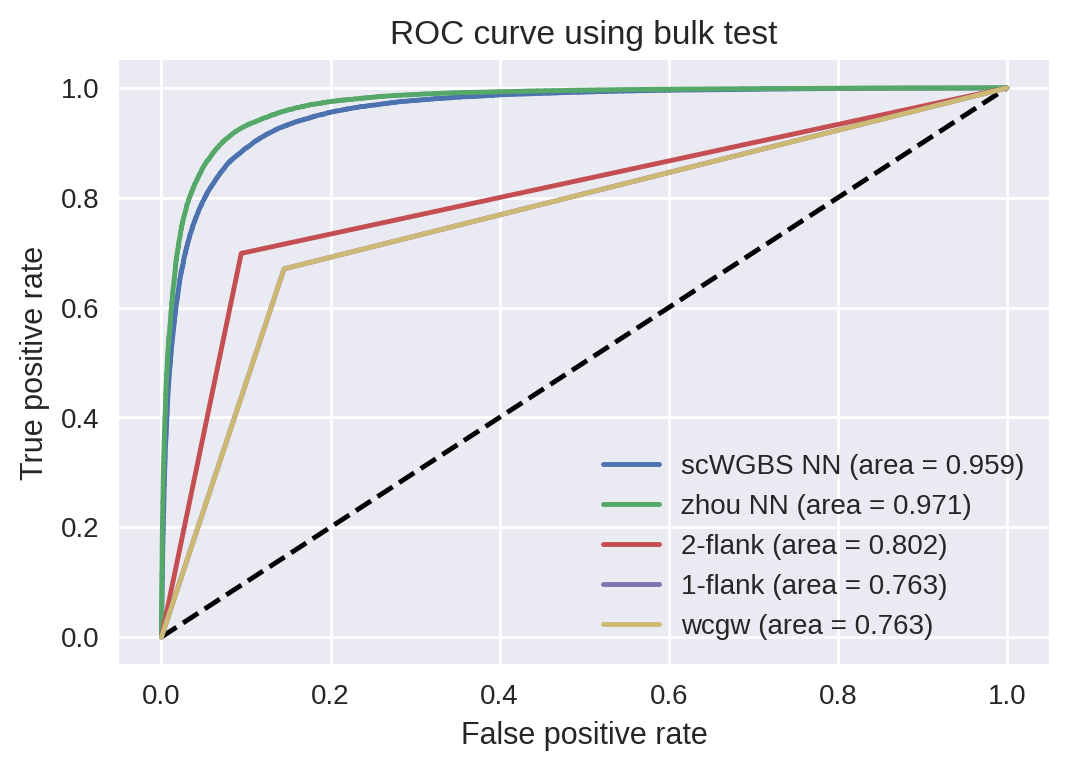

In [9]:
# Get roc curve of bulk dataset
# get_nn_performace(data_path=zhou_data_path, models_folder=zhou_models_folder, title="Bulk dataset")
get_nn_performace(data_path=zhou_solo_data, scwgbs_models_folder=sc_solo_models_folder, bulk_models_folder=zhou_solo_models_folder, title="using bulk test", other_data=scgwbs_data)

Loading data
Removing bad sequences
Load and predict on models
Predict on basic models
Create roc curves


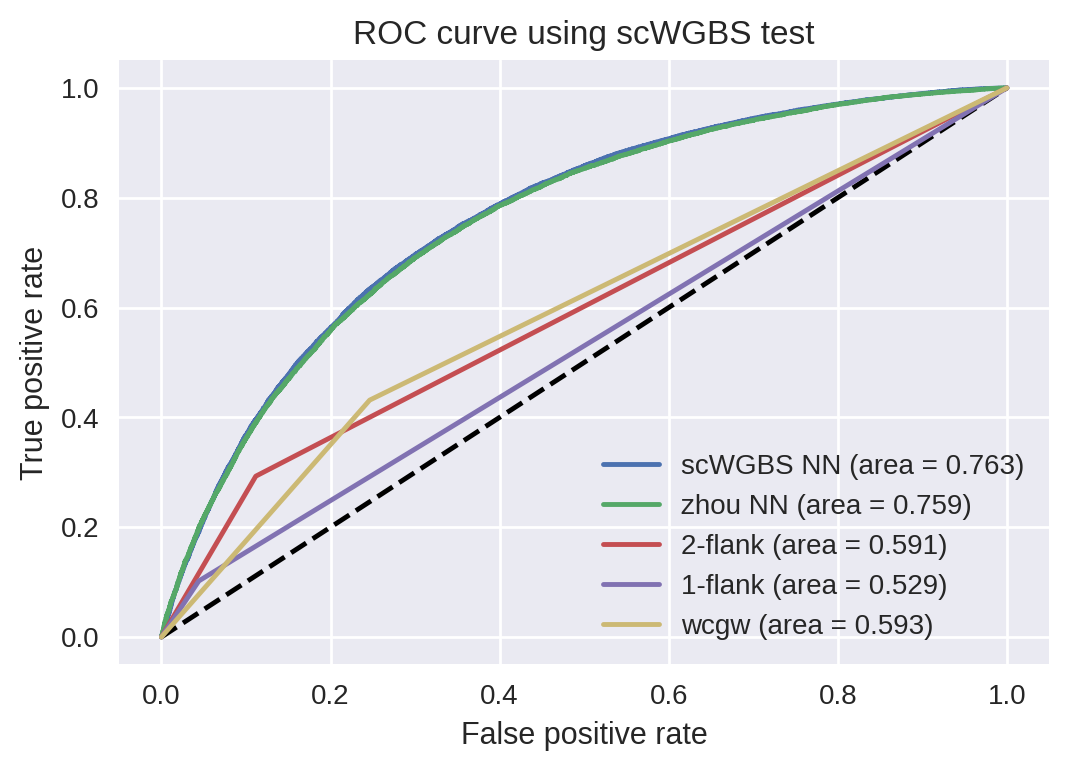

In [10]:
get_nn_performace(other_data=zhou_solo_data, scwgbs_models_folder=sc_solo_models_folder, bulk_models_folder=zhou_solo_models_folder, title="using scWGBS test", data_path=scgwbs_data)

Load data
Removed shared sequences
Pearson correlation value is: 0.9419344841010054
Calculate values for graph


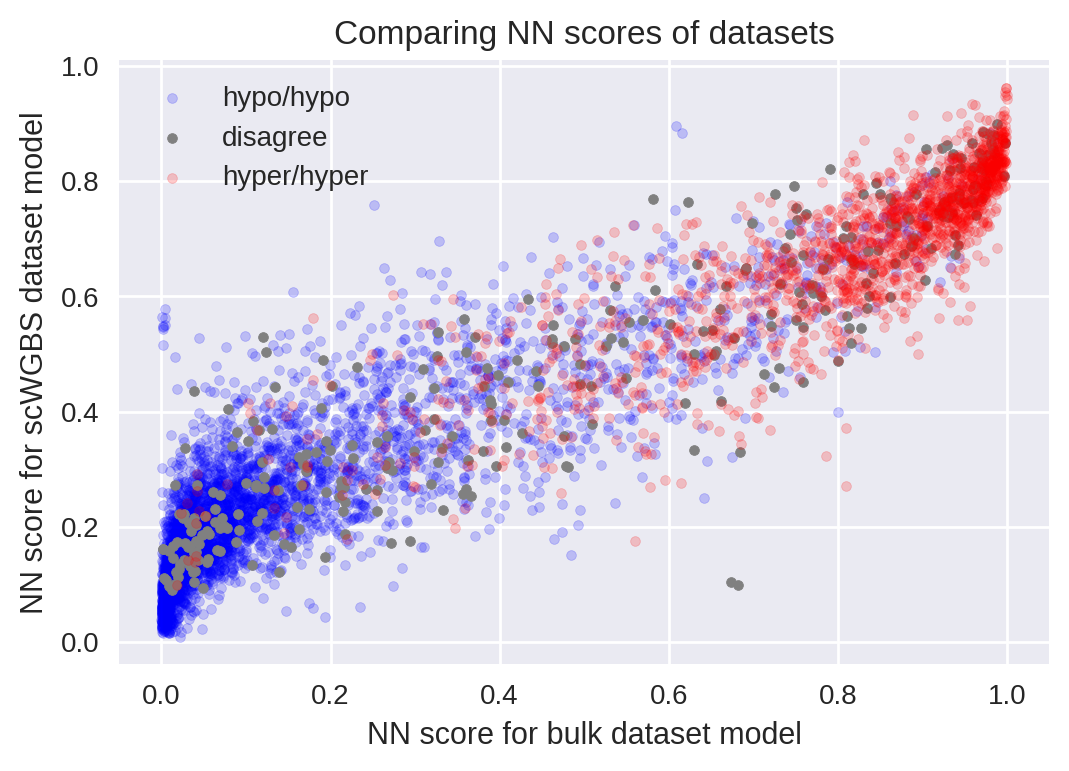

In [11]:
compare_shared_sequences_predictions(scwgbs_data=scgwbs_data, bulk_data=zhou_solo_data, scwgbs_models_folder=sc_solo_models_folder, bulk_models_folder=zhou_solo_models_folder)